<a href="https://colab.research.google.com/github/ARUNKUMARM17/Hyperparameter-tuning-on-wce-curated-colon/blob/main/dl_curated_colon_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
import json
from zipfile import ZipFile

In [ ]:
kaggle_credentails=json.load(open("/content/drive/MyDrive/kaggle.json"))

In [ ]:
import os

In [ ]:

os.environ['KAGGLE_USERNAME']=kaggle_credentails["username"]
os.environ['KAGGLE_KEY']=kaggle_credentails["key"]

In [ ]:
!kaggle datasets download -d francismon/curated-colon-dataset-for-deep-learning

Dataset URL: https://www.kaggle.com/datasets/francismon/curated-colon-dataset-for-deep-learning
License(s): unknown
 99% 1.40G/1.41G [00:10<00:00, 189MB/s]
100% 1.41G/1.41G [00:10<00:00, 150MB/s]


In [ ]:
!kaggle datasets download -d gauravduttakiit/tamil-handwritten-character-recognition

Dataset URL: https://www.kaggle.com/datasets/gauravduttakiit/tamil-handwritten-character-recognition
License(s): CC0-1.0
 87% 41.0M/47.4M [00:00<00:00, 93.2MB/s]
100% 47.4M/47.4M [00:00<00:00, 92.5MB/s]


In [ ]:
with ZipFile("/content/curated-colon-dataset-for-deep-learning.zip",'r')as zip_ref:
  zip_ref.extractall()

In [ ]:
pip install keras-tuner


Trial 5 Complete [00h 35m 43s]
val_accuracy: 0.9610000252723694

Best val_accuracy So Far: 0.9804999828338623
Total elapsed time: 02h 11m 33s
Epoch 1/20
100/100 [==============================] - 111s 937ms/step - loss: 0.3791 - accuracy: 0.8525 - val_loss: 3.4740 - val_accuracy: 0.2500
Epoch 2/20
100/100 [==============================] - 92s 921ms/step - loss: 0.1481 - accuracy: 0.9478 - val_loss: 4.6824 - val_accuracy: 0.2500
Epoch 3/20
100/100 [==============================] - 89s 888ms/step - loss: 0.1062 - accuracy: 0.9606 - val_loss: 4.9075 - val_accuracy: 0.2500
Epoch 4/20
100/100 [==============================] - 93s 923ms/step - loss: 0.1200 - accuracy: 0.9606 - val_loss: 3.9977 - val_accuracy: 0.2660
Epoch 5/20
100/100 [==============================] - 92s 917ms/step - loss: 0.0900 - accuracy: 0.9694 - val_loss: 4.4434 - val_accuracy: 0.2545
Epoch 6/20
100/100 [==============================] - 90s 900ms/step - loss: 0.0955 - accuracy: 0.9659 - val_loss: 3.7710 - val_accu

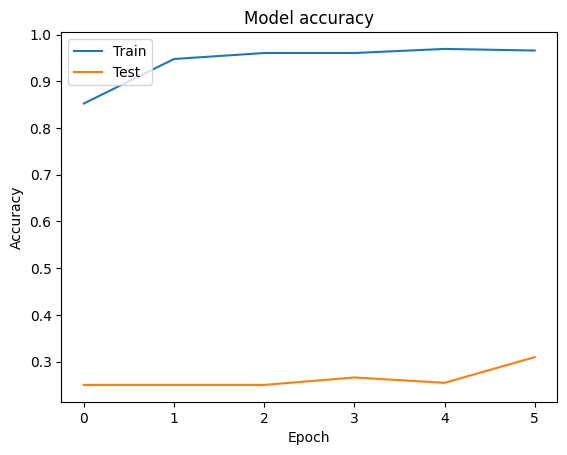

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt

train_dir = '/content/train'
val_dir = '/content/val'
num_classes = 4

def build_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int('units_1', min_value=128, max_value=512, step=128), activation='relu')(x)
    x = Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.7, step=0.1))(x)
    x = BatchNormalization()(x)
    x = Dense(hp.Int('units_2', min_value=64, max_value=512, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout_2', min_value=0.3, max_value=0.7, step=0.1))(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        if isinstance(layer, BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='resnetfinetuning')

tuner.search(
    x=train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(
    x=train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

model.save('wcecolonfine_tuned.h5')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt

train_dir = '/content/train'
val_dir = '/content/val'
num_classes = 4

def build_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int('units_1', min_value=128, max_value=512, step=128), activation='relu')(x)
    x = Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.7, step=0.1))(x)
    x = BatchNormalization()(x)
    x = Dense(hp.Int('units_2', min_value=64, max_value=512, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout_2', min_value=0.3, max_value=0.7, step=0.1))(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        if isinstance(layer, BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='resnet_fine_tuning')

tuner.search(
    x=train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=18,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(
    x=train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=40,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Evaluate model
evaluation = model.evaluate(validation_generator)
print("Validation Accuracy:", evaluation[1])

# Plotting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save model
model.save('resnet_fine_tuned.h5')


Trial 1 Complete [00h 34m 36s]
val_accuracy: 0.949999988079071

Best val_accuracy So Far: 0.949999988079071
Total elapsed time: 00h 34m 36s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
256               |512               |units_1
0.3               |0.4               |dropout_1
192               |128               |units_2
0.6               |0.4               |dropout_2
1e-05             |0.0001            |learning_rate

Epoch 1/18
100/100 [==============================] - 109s 916ms/step - loss: 1.9146 - accuracy: 0.2831 - val_loss: 1.4627 - val_accuracy: 0.2500
Epoch 2/18
100/100 [==============================] - 92s 921ms/step - loss: 1.6878 - accuracy: 0.3537 - val_loss: 1.4496 - val_accuracy: 0.1415
Epoch 3/18
100/100 [==============================] - 90s 893ms/step - loss: 1.4833 - accuracy: 0.4169 - val_loss: 1.3818 - val_accuracy: 0.2345
Epoch 4/18
100/100 [==============================] - 91s 907ms/step - loss: 1.2904 - accuracy: 0.4819 

Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/150
50/50 [==============================] - 71s 908ms/step - loss: 6.4672 - accuracy: 0.8500 - val_loss: 6.3590 - val_accuracy: 0.3290 - lr: 0.0010
Epoch 2/150
50/50 [==============================] - 51s 1s/step - loss: 4.0088 - accuracy: 0.9256 - val_loss: 4.8639 - val_accuracy: 0.2480 - lr: 9.0000e-04
Epoch 3/150
50/50 [==============================] - 44s 885ms/step - loss: 2.5179 - accuracy: 0.9419 - val_loss: 6.7711 - val_accuracy: 0.2500 - lr: 8.1000e-04
Epoch 4/150
50/50 [==============================] - 44s 886ms/step - loss: 1.6506 - accuracy: 0.9569 - val_loss: 5.2350 - val_accuracy: 0.2610 - lr: 7.2900e-04
Epoch 5/150
50/50 [==============================] - 45s 891ms/step - loss: 1.1681 - accuracy: 0.9603 - val_loss: 6.4689 - val_accuracy: 0.2405 - lr: 6.5610e-04
Epoch 6/150
50/50 [==============================] - 

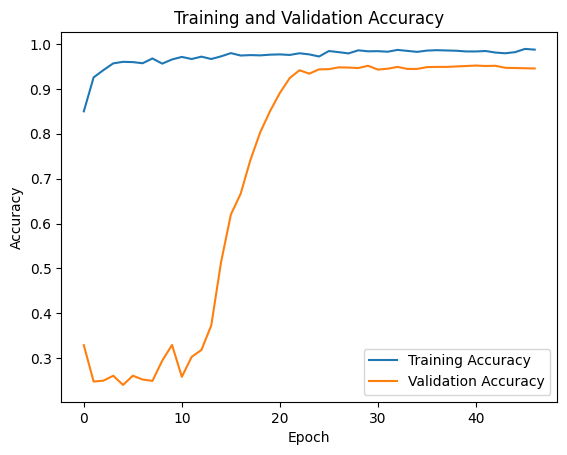

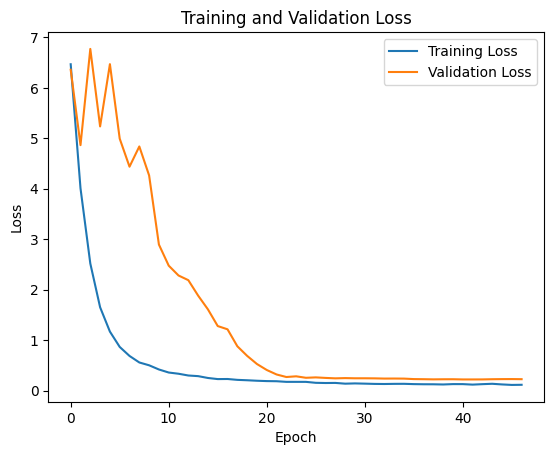

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import os
import matplotlib.pyplot as plt

train_dir = '/content/train'
val_dir = '/content/val'
target_size = (100, 100)
batch_size = 64
num_classes = 4

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

input_layer = Input(shape=(100, 100, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = False

def lr_scheduler(epoch):
  return 0.001 * 0.9 ** epoch

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

num_epochs = 150
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = LearningRateScheduler(lr_scheduler)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, lr_schedule]
)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save('wcecolon.h5')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

test_dir = '/content/test'
model_path = '/content/wcecolon.h5'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False

model = tf.keras.models.load_model(model_path)

test_loss, test_acc = model.evaluate(test_generator)

print('Test accuracy:', test_acc)


Found 800 images belonging to 4 classes.
13/13 [==============================] - 8s 534ms/step - loss: 0.2339 - accuracy: 0.9413
Test accuracy: 0.9412500262260437


Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Epoch 1/150
50/50 [==============================] - 73s 1s/step - loss: 6.7951 - accuracy: 0.7141 - val_loss: 6.7092 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/150
50/50 [==============================] - 46s 934ms/step - loss: 4.8844 - accuracy: 0.8491 - val_loss: 5.3577 - val_accuracy: 0.2500 - lr: 9.0000e-04
Epoch 3/150
50/50 [==============================] - 48s 961ms/step - loss: 3.6041 - accuracy: 0.8691 - val_loss: 4.4014 - val_accuracy: 0.2500 - lr: 8.1000e-04
Epoch 4/150
50/50 [==============================] - 47s 951ms/step - loss: 2.7222 - accuracy: 0.8813 - val_loss: 4.3005 - val_accuracy: 0.2500 - lr: 7.2900e-04
Epoch 5/150
50/50 [==============================] - 48s 966ms/step - loss: 2.1202 - accuracy: 0.8972 - val_loss: 3.2805 - val_accuracy: 0.2590 - lr: 6.5610e-04
Epoch 6/150
50/50 [==============================] - 47s 947ms/step - loss: 1.6926 - accuracy: 0.9056 - val_loss: 2.63

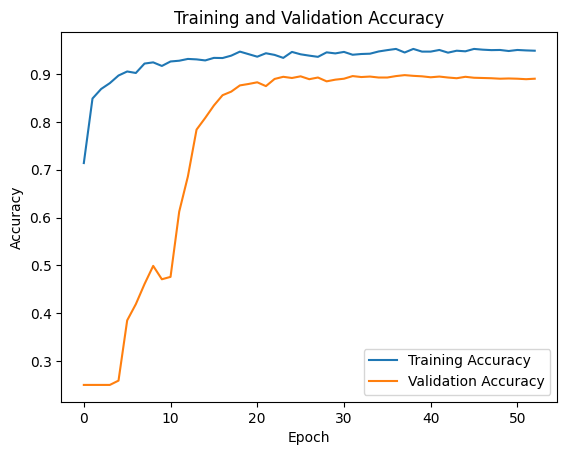

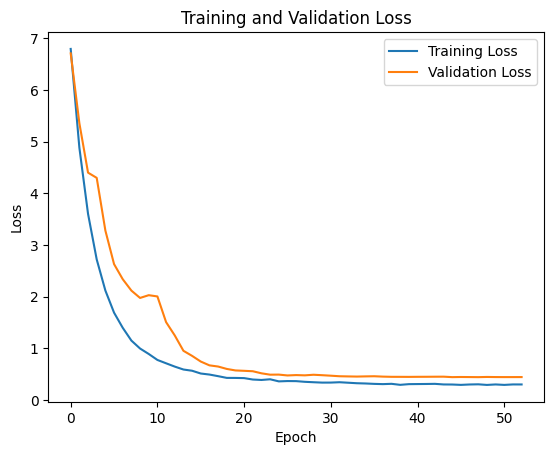

32/32 [==============================] - 16s 468ms/step


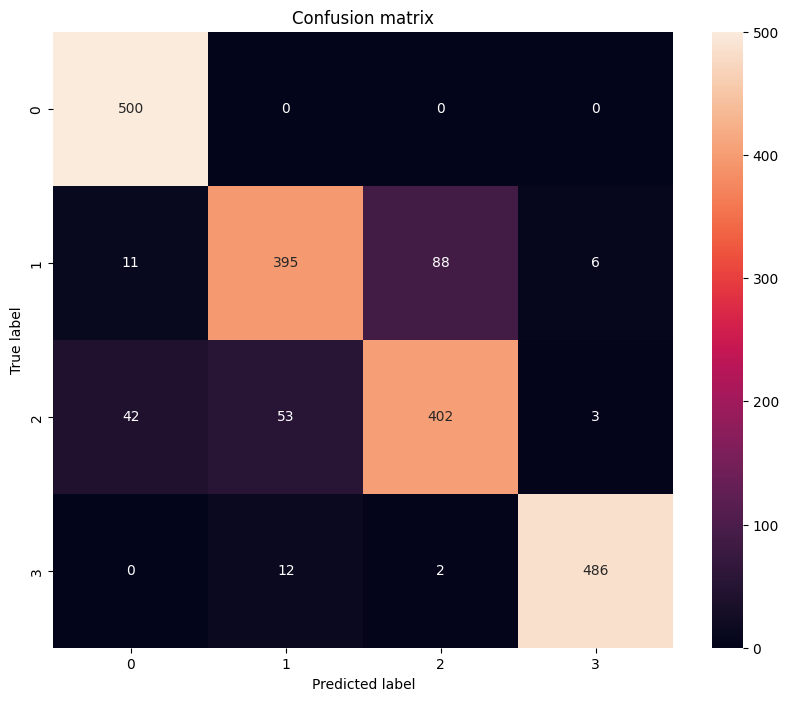

Classification Report
                      precision    recall  f1-score   support

            0_normal       0.90      1.00      0.95       500
1_ulcerative_colitis       0.86      0.79      0.82       500
            2_polyps       0.82      0.80      0.81       500
       3_esophagitis       0.98      0.97      0.98       500

            accuracy                           0.89      2000
           macro avg       0.89      0.89      0.89      2000
        weighted avg       0.89      0.89      0.89      2000



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt

train_dir = '/content/train'
val_dir = '/content/val'
target_size = (100, 100)
batch_size = 64
num_classes = 4

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

input_layer = Input(shape=(100, 100, 3))

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = False

def lr_scheduler(epoch):
  return 0.001 * 0.9 ** epoch

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

num_epochs = 150
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = LearningRateScheduler(lr_scheduler)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, lr_schedule]
)

# Plot training and validation accuracy/loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Y_pred = model.predict(validation_generator)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = validation_generator.classes

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print('Classification Report')
print(classification_report(Y_true, Y_pred_classes, target_names=validation_generator.class_indices.keys()))

model.save('efficientnetwcecolon.h5')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

test_dir = '/content/test'
model_path = '/content/efficientnetwcecolon.h5'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

model = tf.keras.models.load_model(model_path)

test_loss, test_acc = model.evaluate(test_generator)

print('Test accuracy:', test_acc)


Found 800 images belonging to 4 classes.
13/13 [==============================] - 9s 623ms/step - loss: 0.3987 - accuracy: 0.9025
Test accuracy: 0.9024999737739563


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import os


train_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
test_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
target_size = (100, 100)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

input_layer = Input(shape=(100, 100, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
predictions = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

num_epochs = 50  # Increase the number of epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]
)

model.save('diseasemodel_resnet_updated.h5')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Epoch 1/50
1099/1099 [==============================] - 345s 307ms/step - loss: 3.8391 - accuracy: 0.0349 - val_loss: 3.5380 - val_accuracy: 0.0553
Epoch 2/50
1099/1099 [==============================] - 331s 301ms/step - loss: 3.5957 - accuracy: 0.0405 - val_loss: 3.5101 - val_accuracy: 0.0599
Epoch 3/50
1099/1099 [==============================] - 329s 300ms/step - loss: 3.5922 - accuracy: 0.0395 - val_loss: 3.5013 - val_accuracy: 0.0601
Epoch 4/50
1099/1099 [==============================] - 329s 300ms/step - loss: 3.5904 - accuracy: 0.0412 - val_loss: 3.5082 - val_accuracy: 0.0598
Epoch 5/50
1099/1099 [==============================] - 329s 300ms/step - loss: 3.5891 - accuracy: 0.0407 - val_loss: 3.4972 - val_accuracy: 0.0606
Epoch 6/50
1099/1099 [==============================] - 328s 298ms/step - loss: 3.5865 - accuracy: 0.0421 - val_loss: 3.4955 - val_accuracy: 0.0611
Epoch 7/50
1099/1099 [==

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import os
import matplotlib.pyplot as plt

train_dir = '/content/train'
val_dir = '/content/val'
target_size = (224, 224)
batch_size = 64
num_classes = 4  # Replace with the actual number of classes in your dataset

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Rescale validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define model architecture
input_layer = Input(shape=(224, 224, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)  # Increased units
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)  # Increased units
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers except BatchNormalization
for layer in base_model.layers:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = False

# Compile model with optimizer, loss function, and metrics
def lr_scheduler(epoch):
    return 0.001 * 0.9 ** epoch

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
num_epochs = 150
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Increased patience
lr_schedule = LearningRateScheduler(lr_scheduler)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, lr_schedule]
)

# Plot training and validation accuracy/loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save('wcecolon.h5')
